In [70]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm

모델 불러오기

In [51]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
model = AutoModelForSequenceClassification.from_pretrained('/opt/ml/models/roberta_val_batch8_epoch7').to('cuda')

데이터 셋 만들기

In [13]:
class dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    
def preprocessing_dataset(dataset, label_type):
    label = []
    for i in dataset[8]:
        if i == 'blind':
            label.append(100)
        else:
            label.append(label_type[i])
        
    out_dataset = pd.DataFrame({'sentence':dataset[1],'entity_01':dataset[2],'entity_02':dataset[5],'label':label,})
    return out_dataset


def tokenized_dataset(dataset, tokenizer):
    concat_entity = []
    for e01, e02 in zip(dataset['entity_01'], dataset['entity_02']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
        concat_entity,
        list(dataset['sentence']),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=100,
        add_special_tokens=True,
        )
    return tokenized_sentences

In [27]:
train_data = pd.read_csv('~/input/data/train/new_train.tsv', sep='\t', header=None)
eval_data = pd.read_csv('~/input/data/train/val_train.tsv', sep='\t', header=None)
with open('/opt/ml/input/data/label_type.pkl', 'rb') as f:
    label_type = pickle.load(f)

eval_data = preprocessing_dataset(eval_data, label_type)
tokenized_data = tokenized_dataset(eval_data, tokenizer)
eval_dataset = dataset(tokenized_data, eval_data['label'])

data_loader = DataLoader(eval_dataset, 
                         batch_size=40,
                         shuffle=False)

val 데이타 추론

In [63]:
model.eval()
outputs = []
labels = []
for data in tqdm(data_loader):
    with torch.no_grad():
        output = model(
            input_ids=data['input_ids'].to('cuda'),
            attention_mask=data['attention_mask'].to('cuda'),
        )
        logits = output[0]
        logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)
    labels.append(data['labels'].cpu().numpy())
    outputs.append(result)

inference = np.array(outputs).flatten()
labels = np.array(labels).flatten()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


각 레이블별 정답률 확인

In [68]:
temp = []
for vals in inference:
    for val in vals:
        temp.append(val)
inference = np.array(temp)

temp = []
for vals in labels:
    for val in vals:
        temp.append(val)
labels = np.array(temp)

num_ans_dict = Counter(labels)
accuracy_dict = {}

for i in range(42):
    ans_idx = [ idx for idx, ans in enumerate(labels) if ans == i ]
    if len(ans_idx) == 0: continue
    temp_array = inference[ans_idx]
    accuracy_dict[i] = len(temp_array[temp_array==i]) / len(temp_array)

train 데이터의 각 레이블 수 및 각 레이블 별 정답률

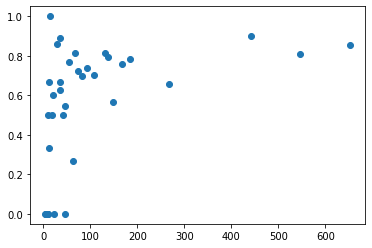

In [112]:
train_label_num = {}
for label in label_type:
    train_label_num[label_type[label]] = len(train_data[train_data[8]==label])

x = [train_label_num[idx] for idx in accuracy_dict]
y = [accuracy_dict[idx] for idx in accuracy_dict]

plt.scatter(x[1:],y[1:])

In [125]:
over_100_list = []
for idx in train_label_num:
    if train_label_num[idx] > 70:
        over_100_list.append(idx)

for idx in over_100_list:
    print(idx, accuracy_dict[idx], train_label_num[idx])

0 0.8069977426636569 3546
1 0.7222222222222222 74
2 0.9 443
4 0.8088235294117647 547
5 0.5675675675675675 149
6 0.782608695652174 185
7 0.7560975609756098 168
8 0.8125 132
9 0.7391304347826086 92
10 0.852760736196319 652
15 0.6567164179104478 268
17 0.7941176470588235 137
20 0.7037037037037037 108
24 0.7 83


In [118]:
label_type

{'관계_없음': 0,
 '인물:배우자': 1,
 '인물:직업/직함': 2,
 '단체:모회사': 3,
 '인물:소속단체': 4,
 '인물:동료': 5,
 '단체:별칭': 6,
 '인물:출신성분/국적': 7,
 '인물:부모님': 8,
 '단체:본사_국가': 9,
 '단체:구성원': 10,
 '인물:기타_친족': 11,
 '단체:창립자': 12,
 '단체:주주': 13,
 '인물:사망_일시': 14,
 '단체:상위_단체': 15,
 '단체:본사_주(도)': 16,
 '단체:제작': 17,
 '인물:사망_원인': 18,
 '인물:출생_도시': 19,
 '단체:본사_도시': 20,
 '인물:자녀': 21,
 '인물:제작': 22,
 '단체:하위_단체': 23,
 '인물:별칭': 24,
 '인물:형제/자매/남매': 25,
 '인물:출생_국가': 26,
 '인물:출생_일시': 27,
 '단체:구성원_수': 28,
 '단체:자회사': 29,
 '인물:거주_주(도)': 30,
 '단체:해산일': 31,
 '인물:거주_도시': 32,
 '단체:창립일': 33,
 '인물:종교': 34,
 '인물:거주_국가': 35,
 '인물:용의자': 36,
 '인물:사망_도시': 37,
 '단체:정치/종교성향': 38,
 '인물:학교': 39,
 '인물:사망_국가': 40,
 '인물:나이': 41}